In [1]:
import os

In [2]:
import simpy as sim
import numpy as np
import pandas as pd


class Vessel(sim.Container):
    def __init__(self, name, env, init=0, capacity=250, resource=None):
        super().__init__(env=env, init=init, capacity=capacity)
        self.name= name
        self.env = env
        self.request = None
        self.resource = resource
        self.in_use = False

    def produce(self, incubation_time=20):
        yield self.env.timeout(incubation_time)

    # Reserve Ressource
    def activate_resource(self):
        self.request = self.resource.request()
        self.in_use = True
        return self.request

    def release_resource(self):
        if self.level != 0:
            raise ValueError("The Resource cannot be released, if not empty")
        self.resource.release(self.request)
        self.in_use = False

    # Move Content
    def fill(self, dv=1):
        if dv > self.capacity-self.level:
            raise ValueError("Full")
        self.put(dv)

    def remove(self, dv=-1):
        if self.level == 0:
            raise ValueError("Empty")
        elif dv < 0:
            self.get(self.level)
        elif self.level < dv:
            raise ValueError("Not Enough")
        else:
            self.get(dv)

    def transfer(self, target_vessel, dv=-1):
        if self.level == 0:
            raise ValueError("Empty")
        elif self.level < dv:
            raise ValueError("Not Enough")
        if dv < 0:
            tv = self.level
        else:
            tv = dv
        self.get(tv)
        target_vessel.fill(tv)


class factory(object):  # Equipment
    def __init__(self, env, num_ferm_stage1=4, num_ferm_stage2=2,
                 num_ferm_stage3=2, num_ferm_stage4=6, num_harvester=1):
        self.env = env
        self.stats = None

        #Upstream
        self.ferm_stage1 = sim.Resource(env, capacity=num_ferm_stage1)
        stage1_vessel =lambda : Vessel("Vessel_S1", env, init=0, capacity=60, resource=self.ferm_stage1)
        self.ferm_stage1.vessels = [stage1_vessel() for i in range(num_ferm_stage1)]

        self.ferm_stage1.get_vessel = stage1_vessel

        self.ferm_stage2 = sim.Resource(env, capacity=num_ferm_stage2)
        self.ferm_stage2.get_vessel = lambda : Vessel("Vessel_S2", env, init=0, capacity=250, resource=self.ferm_stage2)
        self.ferm_stage3 = sim.Resource(env, capacity=num_ferm_stage3)
        self.ferm_stage3.get_vessel = lambda : Vessel("Vessel_S3",env, init=0, capacity=3000, resource=self.ferm_stage3)
        self.ferm_stage4 = sim.Resource(env, capacity=num_ferm_stage4)
        self.ferm_stage4.get_vessel = lambda : Vessel("Vessel_S4",env, init=0, capacity=14000, resource=self.ferm_stage4)
        self.harvester = sim.Resource(env, capacity=num_harvester)
        self.harvester.get_vessel = lambda : Vessel("harvester",env, init=0, capacity=500, resource=self.harvester)



In [3]:
# Process Modell
class Monitor:
    def __init__(self, env):
        self.env = env
        self._equippment_monitor = []
        self._process_monitor = []
        self._campaign_monitor = []
        self._ressource_monitor = []

    @property
    def equippment_monitor(self):
        return pd.DataFrame(self._equippment_monitor)

    @property
    def process_monitor(self):
        return pd.DataFrame(self._process_monitor)

    @property
    def campaign_monitor(self):
        return pd.DataFrame(self._campaign_monitor)

    @property
    def ressource_monitor(self):
        return pd.DataFrame(self._ressource_monitor)

    def record_vessel(self, campaignID, vessel, action):
        equippment_usage = {"name": vessel.name, "Campaign_ID": campaignID, "time": self.env.now, "level": vessel.level, "action": action}
        self._equippment_monitor.append(equippment_usage)

    def record_process(self, campaignID, process, action):
        process_monitor = {"name": process, "Campaign_ID": campaignID, "time": self.env.now, "action": action}
        self._process_monitor.append(process_monitor)

    def record_campaign(self, campaignID, action):
        product_monitor = {"name": campaignID, "time": self.env.now, "action": action}
        self._campaign_monitor.append(product_monitor)

    def record_ressource(self, campaignID, process, ressource, requires):
        ressource_monitor = {"campaign": campaignID, "process":process, "ressource":ressource, "time": self.env.now, "requires": requires}
        self._ressource_monitor.append(ressource_monitor)


def campaignA_upstream_generateMedium():
    pass


def campaignA_cip(env, vessel):
    yield env.process(vessel.produce(incubation_time=30))


def campaignA_upstream(env, runID, plant, monitor):
    product = "Bruehe"

    #Stage 1
    ## Init
    active_vessel_stage1 = plant.ferm_stage1.get_vessel()
    yield active_vessel_stage1.activate_resource()
    monitor.record_campaign(runID, "Start")
    monitor.record_process(campaignID=runID, process=product, action="Campaign Start")
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage1, action="allocation_start")
    active_vessel_stage1.fill(60)

    ## prod1
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage1, action="prod_start")
    yield env.process(active_vessel_stage1.produce(incubation_time=30))
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage1, action="prod_end")


    #Stage 2
    active_vessel_stage2 = plant.ferm_stage2.get_vessel()
    yield active_vessel_stage2.activate_resource()
    active_vessel_stage1.transfer(active_vessel_stage2, dv=60)
    yield env.process(campaignA_cip(env, active_vessel_stage1))
    active_vessel_stage1.release_resource()
    monitor.record_process(campaignID=runID, process=product, action="Stage1 Done")
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage1, action="allocation_end")
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage2, action="allocation_start")

    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage2, action="prod_start")
    yield env.process(active_vessel_stage2.produce(40))
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage2, action="prod_end")


    #Stage 3
    active_vessel_stage3 = plant.ferm_stage3.get_vessel()
    yield active_vessel_stage3.activate_resource()
    active_vessel_stage2.transfer(active_vessel_stage3)
    active_vessel_stage2.release_resource()
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage2, action="allocation_end")
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage3, action="allocation_start")
    monitor.record_process(campaignID=runID, process=product, action="Stage2 Done")

    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage3, action="production_start")
    yield env.process(active_vessel_stage3.produce(80))
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage3, action="production_end")


    #Stage 4
    active_vessel_stage4 = plant.ferm_stage4.get_vessel()
    yield active_vessel_stage4.activate_resource()
    active_vessel_stage3.transfer(active_vessel_stage4)
    active_vessel_stage3.release_resource()
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage4, action="allocation_start")
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage3, action="allocation_end")
    monitor.record_process(campaignID=runID, process=product, action="Stage3 Done")

    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage4, action="prod_start")
    yield env.process(active_vessel_stage4.produce(100))
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage4, action="prod_end")

    #Harvest
    active_harvester = plant.harvester.get_vessel()
    yield active_harvester.activate_resource()
    active_vessel_stage4.transfer(active_harvester)
    active_vessel_stage4.release_resource()
    monitor.record_vessel(campaignID=runID, vessel=active_harvester, action="allocation_start")
    monitor.record_vessel(campaignID=runID, vessel=active_vessel_stage4, action="allocation_end")
    monitor.record_process(campaignID=runID, process=product, action="Stage4 Done")

    monitor.record_vessel(campaignID=runID, vessel=active_harvester, action="production_start")
    yield env.process(active_harvester.produce(30))
    monitor.record_vessel(campaignID=runID, vessel=active_harvester, action="production_end")

    active_harvester.remove()
    active_harvester.release_resource()
    monitor.record_vessel(campaignID=runID, vessel=active_harvester, action="allocation_end")
    monitor.record_process(campaignID=runID, process=product, action="Harvester Done")
    monitor.record_process(campaignID=runID, process=product, action="Campaign Done")

    # Post Analysis
    monitor.record_campaign(runID, "End")

def campaignA(env, runID, plant:factory, monitor): # Process Control
    yield env.process(campaignA_upstream(env, runID, plant, monitor))



In [4]:
import time

def run_campaign_on_factory(env, campaign, plant:factory, monitor, num_runs=10): #Simulation Control
    for run in range(num_runs):
        env.process(campaign(env, run, plant, monitor))
        yield env.timeout(0)  # Wait a bit before generating a new person

# Run simulation:
monitors = []
for i in range(1,6):
    print(i)
    env = sim.Environment()
    monitor = Monitor(env=env)
    # Plant Modell
    plant = factory(env=env,
                    num_ferm_stage1=6, num_ferm_stage2=i, num_ferm_stage3=i, num_ferm_stage4=i*2,
                    num_harvester=2)

    # Simulation
    simulation = run_campaign_on_factory(env=env, campaign=campaignA,
                                         plant=plant, monitor=monitor, num_runs=20)
    env.process(simulation)
    env.run()

    # Results
    monitor.num_stage2= i
    monitors.append(monitor)


1
2
3
4
5


In [13]:
monitor = monitors[-1]
df_product = monitor.process_monitor
df_equippment = monitor.equippment_monitor
df_campaign = monitor.campaign_monitor
df_ressource = monitor.ressource_monitor
df_equippment

,name,Campaign_ID,time,level,action
0,Vessel_S1,0,0,0,allocation_start
1,Vessel_S1,0,0,60,prod_start
2,Vessel_S1,1,0,0,allocation_start
3,Vessel_S1,1,0,60,prod_start
4,Vessel_S1,2,0,0,allocation_start
...,...,...,...,...,...
395,harvester,19,580,60,production_start
396,harvester,18,590,60,production_end
397,harvester,18,590,0,allocation_end
398,harvester,19,610,60,production_end


0
1
2


/tmp/ipykernel_9685/813318080.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  duration = float(sub_df.loc[sub_df["action"]=="End", "time"]) - float(sub_df.loc[sub_df["action"]=="Start", "time"])


3
4


Text(0.5, 0, 'Run')

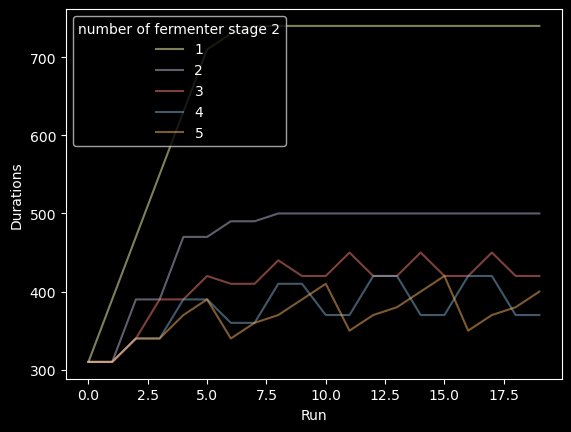

In [14]:
from matplotlib import pyplot as plt

for j, monitor in enumerate(monitors):
    print(j)
    durations=[]
    df_active_campaign = monitor.campaign_monitor
    for i in df_active_campaign["name"].unique():
        sub_df = df_active_campaign.loc[df_active_campaign["name"] == i]
        duration = float(sub_df.loc[sub_df["action"]=="End", "time"]) - float(sub_df.loc[sub_df["action"]=="Start", "time"])
        durations.append(duration)
    plt.plot(durations, alpha=0.5, label=monitor.num_stage2, c=f"C{j+1}")

plt.legend(title="number of fermenter stage 2")
plt.ylabel("Durations")
plt.xlabel("Run")

In [15]:
usage = []
durations = []
for campaignID in df_equippment["Campaign_ID"].unique():
    ddf = df_equippment.loc[df_equippment["Campaign_ID"] == campaignID]

    for vessel in ddf["name"].unique():
        sub_df = ddf.loc[ddf["name"] == vessel]

        start_t = float(sub_df.loc[sub_df["action"]=="allocation_start", "time"])
        end_t = float(sub_df.loc[sub_df["action"]=="allocation_end", "time"])
        duration = end_t - start_t

        usage.append((vessel, start_t, end_t, int(campaignID)))
        durations.append((vessel, campaignID, duration))
        print(campaignID, vessel, duration)



/tmp/ipykernel_9685/81514154.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  start_t = float(sub_df.loc[sub_df["action"]=="allocation_start", "time"])
/tmp/ipykernel_9685/81514154.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  end_t = float(sub_df.loc[sub_df["action"]=="allocation_end", "time"])


0 Vessel_S1 60.0
0 Vessel_S2 40.0
0 Vessel_S3 80.0
0 Vessel_S4 100.0
0 harvester 30.0
1 Vessel_S1 60.0
1 Vessel_S2 40.0
1 Vessel_S3 80.0
1 Vessel_S4 100.0
1 harvester 30.0
2 Vessel_S1 60.0
2 Vessel_S2 40.0
2 Vessel_S3 80.0
2 Vessel_S4 130.0
2 harvester 30.0
3 Vessel_S1 60.0
3 Vessel_S2 40.0
3 Vessel_S3 80.0
3 Vessel_S4 130.0
3 harvester 30.0
4 Vessel_S1 60.0
4 Vessel_S2 40.0
4 Vessel_S3 80.0
4 Vessel_S4 160.0
4 harvester 30.0
5 Vessel_S1 130.0
5 Vessel_S2 50.0
5 Vessel_S3 80.0
5 Vessel_S4 100.0
5 harvester 30.0
6 Vessel_S1 70.0
6 Vessel_S2 50.0
6 Vessel_S3 80.0
6 Vessel_S4 110.0
6 harvester 30.0
7 Vessel_S1 70.0
7 Vessel_S2 50.0
7 Vessel_S3 80.0
7 Vessel_S4 130.0
7 harvester 30.0
8 Vessel_S1 70.0
8 Vessel_S2 50.0
8 Vessel_S3 80.0
8 Vessel_S4 140.0
8 harvester 30.0
9 Vessel_S1 70.0
9 Vessel_S2 50.0
9 Vessel_S3 80.0
9 Vessel_S4 160.0
9 harvester 30.0
10 Vessel_S1 150.0
10 Vessel_S2 50.0
10 Vessel_S3 80.0
10 Vessel_S4 100.0
10 harvester 30.0
11 Vessel_S1 80.0
11 Vessel_S2 50.0
11 Vessel_S

(0.0, 250.0)

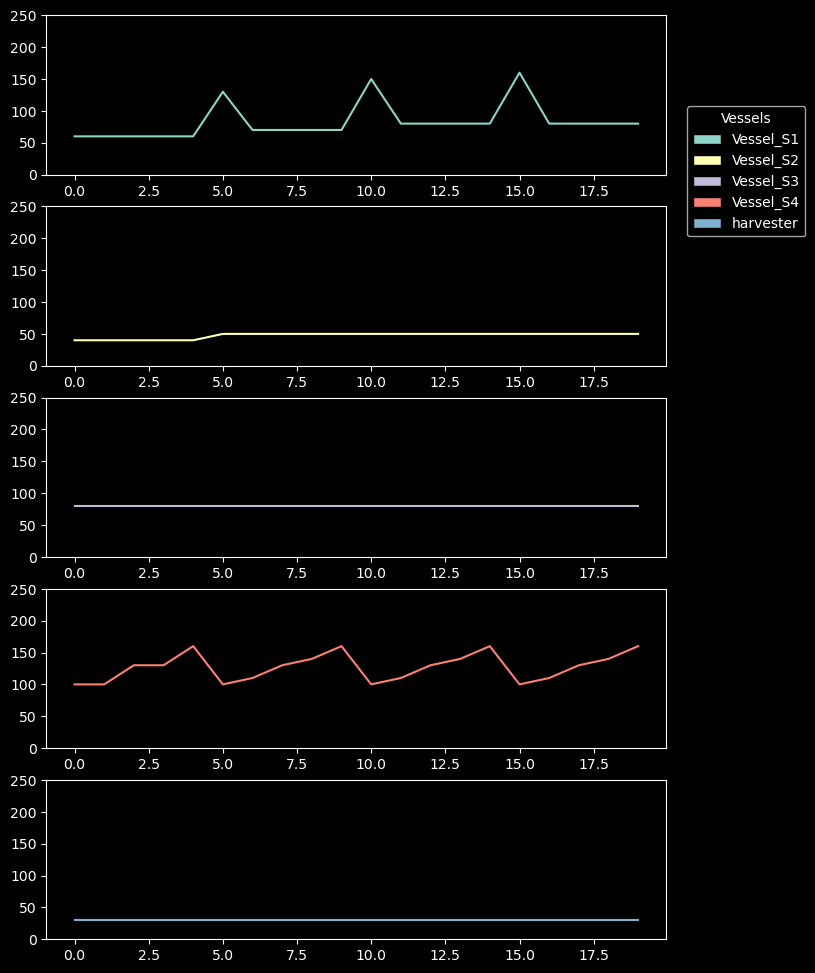

In [16]:
df = pd.DataFrame(durations, columns=["vessel", "campaign", "duration"])
vessel_names =list(ddf["name"].unique())
fig, axs = plt.subplots(nrows=len(vessel_names), sharey=True, figsize=(8, 12))
i=0
leg = []
for ax, vessel in zip(axs, sorted(vessel_names, key=lambda x: x[-1])):
    sdf = df.loc[df["vessel"] == vessel]
    ax.plot(sdf["campaign"], sdf["duration"],label=vessel, c=f"C{i}")
    leg.append((i, vessel))
    i+=1

from matplotlib.patches import Patch
legend_handles = [Patch(facecolor=f"C{i}", edgecolor="black", label=name)
                  for i, name in leg]
fig.legend(handles=legend_handles, title="Vessels", bbox_to_anchor=(1, 0.75), loc="center")
ax.set_ylim([0,250])

0 Vessel_S1 0.0 60.0
0 Vessel_S2 60.0 40.0
0 Vessel_S3 100.0 80.0
0 Vessel_S4 180.0 100.0
0 harvester 280.0 30.0
1 Vessel_S1 0.0 130.0
1 Vessel_S2 130.0 50.0
1 Vessel_S3 180.0 80.0
1 Vessel_S4 260.0 100.0
1 harvester 360.0 30.0
2 Vessel_S1 0.0 210.0
2 Vessel_S2 210.0 50.0
2 Vessel_S3 260.0 80.0
2 Vessel_S4 340.0 100.0
2 harvester 440.0 30.0
3 Vessel_S1 0.0 290.0
3 Vessel_S2 290.0 50.0
3 Vessel_S3 340.0 80.0
3 Vessel_S4 420.0 100.0
3 harvester 520.0 30.0
4 Vessel_S1 0.0 370.0
4 Vessel_S2 370.0 50.0
4 Vessel_S3 420.0 80.0
4 Vessel_S4 500.0 100.0
4 harvester 600.0 30.0
5 Vessel_S1 0.0 450.0
5 Vessel_S2 450.0 50.0
5 Vessel_S3 500.0 80.0
5 Vessel_S4 580.0 100.0
5 harvester 680.0 30.0
6 Vessel_S1 60.0 470.0
6 Vessel_S2 530.0 50.0
6 Vessel_S3 580.0 80.0
6 Vessel_S4 660.0 100.0
6 harvester 760.0 30.0
7 Vessel_S1 130.0 480.0
7 Vessel_S2 610.0 50.0
7 Vessel_S3 660.0 80.0
7 Vessel_S4 740.0 100.0
7 harvester 840.0 30.0
8 Vessel_S1 210.0 480.0
8 Vessel_S2 690.0 50.0
8 Vessel_S3 740.0 80.0
8 Vessel_

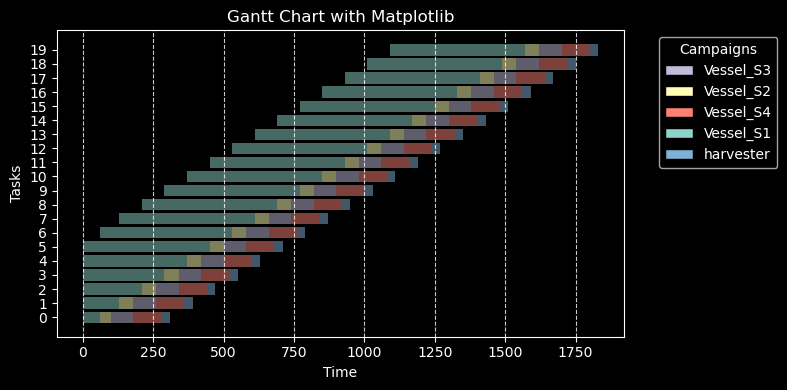

In [10]:

import matplotlib.pyplot as plt
start_r = 2
stop = 6
# Sample task data: (Task Name, Start Date, End Date)
tasks = usage

# Prepare data for plotting
fig, ax = plt.subplots(figsize=(8, 4))

tasksz = list(df_equippment["name"].unique())
yticklabels = list(df_equippment["Campaign_ID"].unique())
yticks = list(range(len(yticklabels)))

cids = []
for i, (task, start, end, campaign) in enumerate(tasks):

    cids.append(task)
    start_num = start
    end_num = end
    duration = end_num - start_num
    print(campaign, task, start, duration)

    # Plot the task as a horizontal bar
    ax.broken_barh([(start_num, duration)], (yticklabels.index(campaign) - 0.4, 0.8), facecolors=f"C{tasksz.index(task)}", alpha=0.5)

# Configure Y-axis
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

# Labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Tasks")
ax.set_title("Gantt Chart with Matplotlib")

# Grid for better readability
ax.grid(True, axis="x", linestyle="--", alpha=0.8)

# Create legend from phase_colors
from matplotlib.patches import Patch
legend_handles = [Patch(facecolor=f"C{tasksz.index(cid)}", edgecolor="black", label=cid)
                  for cid in set(cids)]
ax.legend(handles=legend_handles, title="Campaigns", bbox_to_anchor=(1.05, 1), loc="upper left")


plt.tight_layout()
plt.show()


In [11]:
import networkx as nx

def to_graph(self):
    g = nx.Graph()
    g.add_node(self, name=self.name, degree=2-self.lever)
    ln=self
    for n in self.sub_compartments:
        g.add_node(n, name=n.name, degree=2-n.lever)
        g.add_edge(ln, n)
        ln=n

    lc = None
    for c in p.sub_compartments:
        g.add_edge(c, c.sub_compartments[0], type=0)
        for c2 in c.sub_compartments:
            g.add_node(c2, name=c2.name, degree=2-c2.lever)
            if lc is not None:
                g.add_edge(lc, c2, type=1)
            lc = c2
    return g
